## 01: Prepare Data

Same as last blog, download and extract training and validation data.

In [1]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip \
    -O /tmp/rps.zip

--2020-08-20 11:21:49--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 173.194.76.128, 64.233.184.128, 64.233.166.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|173.194.76.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 200682221 (191M) [application/zip]
Saving to: ‘/tmp/rps.zip’

/tmp/rps.zip        100%[===================>] 191.38M  87.4MB/s    in 2.2s    

2020-08-20 11:21:51 (87.4 MB/s) - ‘/tmp/rps.zip’ saved [200682221/200682221]



In [2]:
!wget --no-check-certificate \
    https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip \
    -O /tmp/rps-test-set.zip

--2020-08-20 11:22:05--  https://storage.googleapis.com/laurencemoroney-blog.appspot.com/rps-test-set.zip
Resolving storage.googleapis.com (storage.googleapis.com)... 74.125.133.128, 173.194.76.128, 66.102.1.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|74.125.133.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 29516758 (28M) [application/zip]
Saving to: ‘/tmp/rps-test-set.zip’

/tmp/rps-test-set.z 100%[===================>]  28.15M  58.7MB/s    in 0.5s    

2020-08-20 11:22:06 (58.7 MB/s) - ‘/tmp/rps-test-set.zip’ saved [29516758/29516758]



In [3]:
import os
import zipfile

local_zip = '/tmp/rps.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

local_zip = '/tmp/rps-test-set.zip'
zip_ref = zipfile.ZipFile(local_zip, 'r')
zip_ref.extractall('/tmp/')
zip_ref.close()

Data augmentation and prepare data generator for model training.

In [4]:
import tensorflow as tf
import keras_preprocessing
from keras_preprocessing import image
from keras_preprocessing.image import ImageDataGenerator

TRAINING_DIR = "/tmp/rps/"
training_datagen = ImageDataGenerator(
      rescale = 1./255,        # limit the grey value to 0-1
	    rotation_range=40,       # the image can rotate from 0-40 degree
      width_shift_range=0.2,   #
      height_shift_range=0.2,  # the image can shift
      shear_range=0.2,         # the image can shear
      zoom_range=0.2,          # the image can zoom in and out to at most 20 percent
      horizontal_flip=True,    # the image can flip horizontally
      fill_mode='nearest')     # fill blank pixels after processing

VALIDATION_DIR = "/tmp/rps-test-set/"
validation_datagen = ImageDataGenerator(rescale = 1./255) # only augment training dataset

train_generator = training_datagen.flow_from_directory(
	TRAINING_DIR,
	target_size=(150,150),
	class_mode='categorical', # multi-class mode, if two-class use 'binary'
  batch_size=126
)

validation_generator = validation_datagen.flow_from_directory(
	VALIDATION_DIR,
	target_size=(150,150),
	class_mode='categorical',
  batch_size=126
)

Found 2520 images belonging to 3 classes.
Found 372 images belonging to 3 classes.


## 02: Build Model From Transfer Learning

In this part, we will use transfer learning to build a bigger and deeper neural network. Firstly let's download the pre-trained *InceptionV3* model including its weights, extract the layers and freeze the weights not being trained later.

In [6]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
# download preloaded weights
!wget --no-check-certificate \
    https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5 \
    -O /tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5

local_weights_file = '/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

# load pre-trained model
pre_trained_model = InceptionV3(input_shape = (150, 150, 3), # corresponds with our data
                                include_top = False, # cut last FC layer, to be replaced by ours
                                weights = None) # clear weights
# load weights
pre_trained_model.load_weights(local_weights_file)
# lock (freeze) the pre-trained layers
for layer in pre_trained_model.layers:
  layer.trainable = False
  
# pre_trained_model.summary()

# get the last layer of pre-trained layers from summary()
last_layer = pre_trained_model.get_layer('mixed7') 
print('last layer output shape: ', last_layer.output_shape)
last_output = last_layer.output

--2020-08-20 11:38:31--  https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5
Resolving storage.googleapis.com (storage.googleapis.com)... 64.233.167.128, 74.125.71.128, 74.125.140.128, ...
Connecting to storage.googleapis.com (storage.googleapis.com)|64.233.167.128|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 87910968 (84M) [application/x-hdf]
Saving to: ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’

/tmp/inception_v3_w 100%[===================>]  83.84M  29.7MB/s    in 2.8s    

2020-08-20 11:38:34 (29.7 MB/s) - ‘/tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5’ saved [87910968/87910968]

last layer output shape:  (None, 7, 7, 768)


Now we can build our model by extending the pretrained *InceptionV3* model

In [10]:
from tensorflow.keras.optimizers import RMSprop

# Flatten the output layer to 1 dimension
x = tf.keras.layers.Flatten()(last_output)
# Add a fully connected layer with 1,024 hidden units and ReLU activation
x = tf.keras.layers.Dense(1024, activation='relu')(x)
# Add a dropout rate of 0.2
x = tf.keras.layers.Dropout(0.4)(x)                  
# Add a final sigmoid layer for classification
x = tf.keras.layers.Dense(3, activation='softmax')(x)           

# build final model with pre-trained layers
model = tf.keras.Model( pre_trained_model.input, x) 
# compile model
model.compile(optimizer = RMSprop(lr=0.0001), 
              loss = 'categorical_crossentropy', 
              metrics = ['accuracy'])

## 03: Training and Visualization

In [11]:
history = model.fit(train_generator, epochs=25, steps_per_epoch=20, validation_data = validation_generator, verbose = 1, validation_steps=3)

model.save("rps.h5") # save the trained model with trained weights

Epoch 1/25
20/20 [==============================] - 25s 1s/step - loss: 0.8723 - accuracy: 0.7901 - val_loss: 0.6861 - val_accuracy: 0.7231
Epoch 2/25
20/20 [==============================] - 23s 1s/step - loss: 0.2579 - accuracy: 0.8996 - val_loss: 0.4400 - val_accuracy: 0.8118
Epoch 3/25
20/20 [==============================] - 23s 1s/step - loss: 0.1293 - accuracy: 0.9552 - val_loss: 0.2386 - val_accuracy: 0.8898
Epoch 4/25
20/20 [==============================] - 23s 1s/step - loss: 0.1577 - accuracy: 0.9560 - val_loss: 0.2649 - val_accuracy: 0.8978
Epoch 5/25
20/20 [==============================] - 23s 1s/step - loss: 0.0580 - accuracy: 0.9778 - val_loss: 0.5463 - val_accuracy: 0.7769
Epoch 6/25
20/20 [==============================] - 23s 1s/step - loss: 0.0473 - accuracy: 0.9837 - val_loss: 0.1699 - val_accuracy: 0.9462
Epoch 7/25
20/20 [==============================] - 23s 1s/step - loss: 0.0927 - accuracy: 0.9679 - val_loss: 1.4277 - val_accuracy: 0.6398
Epoch 8/25
20/20 [==

Let’s have a look at the training process, watching how accuracy and loss change over epochs.

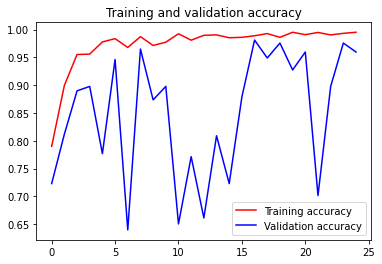

<Figure size 432x288 with 0 Axes>

In [12]:
import matplotlib.pyplot as plt
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend(loc=0)
plt.figure()

plt.show()

Absolutely this result is no better than last blog, especially for the validation set. The main reason is that the *InceptionV3* model is trained for object classification, but our case is hand gesture, which is not so relative. This is also one big problem in transfer learning to find the relation between different cases. Therefore, instead of using the fixed weights, we can try using them for initialization and let them be trained during the process, which may lead to better results.